In [1]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 7.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance
import numpy as np
import pandas as pd
import pandas
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import cufflinks as cf
cf.set_config_file(offline=True)

import warnings
warnings.filterwarnings("ignore")


In [3]:
from ActMng import AccountManager 

In [4]:
starting_capital = 100000
allocation = 0.8

symbol = 'SPY'

long_trend_days = 12
short_trend_days = 6

In [5]:
def fetch_data(symbol:str='SPY', start_date:str='2020', end_date:str=None):
    
    if end_date is None:
        end = pandas.Timestamp.now()
    else:
        end = end_date
    
    return pdr.get_data_yahoo(symbol, pandas.Timestamp(start_date), pandas.Timestamp(end))[['Open','Close']]
df = fetch_data(symbol)

[*********************100%***********************]  1 of 1 completed


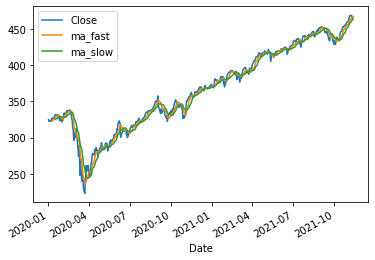

In [6]:
fast_trend = df.Open.rolling(window=short_trend_days).mean()
slow_trend = df.Open.rolling(window=long_trend_days).mean()

df['ma_fast'] = fast_trend
df['ma_slow'] = slow_trend
df[['Close','ma_fast','ma_slow']].plot()

In [7]:
df['trade_direction'] = np.sign(fast_trend-slow_trend)
df

,Open,Close,ma_fast,ma_slow,trade_direction
Date,,,,,
2020-01-02,323.540009,324.869995,NaN,NaN,NaN
2020-01-03,321.160004,322.410004,NaN,NaN,NaN
2020-01-06,320.489990,323.640015,NaN,NaN,NaN
2020-01-07,323.019989,322.730011,NaN,NaN,NaN
2020-01-08,322.940002,324.450012,NaN,NaN,NaN
...,...,...,...,...,...
2021-11-08,469.700012,468.929993,464.359996,459.879166,1.0
2021-11-09,469.320007,467.380005,465.863332,461.228333,1.0
2021-11-10,465.579987,463.619995,466.756663,462.169998,1.0


In [8]:
#Determine the direction of the moving average differences
df_trades = df['trade_direction'].dropna().diff().dropna().apply(np.sign).astype('int8')
df_trades = pandas.DataFrame(df_trades[df_trades !=0])

#Label our intended trades
df_trades['trade'] = df['trade_direction'].map({1:'Long',-1:'Short'})
df['trades'] = df_trades['trade']


In [9]:
#Label our opening trade after removing our window period
df['trades'].replace(pandas.np.NaN,'None',inplace=True)
df = df.dropna()
df['trades'].iloc[0]=('Long' if df['trade_direction'].iloc[0]==1.0 else 'Short')
df

,Open,Close,ma_fast,ma_slow,trade_direction,trades
Date,,,,,,
2020-01-17,331.700012,331.950012,328.316676,325.600838,1.0,Long
2020-01-21,330.899994,331.299988,328.918340,326.214170,1.0,None
2020-01-22,332.239990,331.339996,329.893336,327.137502,1.0,None
2020-01-23,330.630005,331.720001,330.420003,327.982503,1.0,None
2020-01-24,332.440002,328.769989,331.268336,328.767504,1.0,None
...,...,...,...,...,...,...
2021-11-08,469.700012,468.929993,464.359996,459.879166,1.0,None
2021-11-09,469.320007,467.380005,465.863332,461.228333,1.0,None
2021-11-10,465.579987,463.619995,466.756663,462.169998,1.0,None


In [10]:
# Our trading strategy implementation - feel free to brose ActMng.py if you are curious.
trading_strategy = AccountManager(symbol=symbol,trades_df=df,starting_capital=starting_capital,allocation_amount=allocation)
results = trading_strategy.run()

In [11]:
#Here we can see a day by day breakdown of the account
results['result_df']

,Open,Close,ma_fast,ma_slow,trade_direction,trades,account_val,cash_bal,position,position_changes,fees
2020-01-17,331.700012,331.950012,328.316676,325.600838,1.0,Long,100059.295000,19999.591056,241.18,241.18,1.0
2020-01-21,330.899994,331.299988,328.918340,326.214170,1.0,None,99902.522112,19999.591056,241.18,0.00,0.0
2020-01-22,332.239990,331.339996,329.893336,327.137502,1.0,None,99912.171373,19999.591056,241.18,0.00,0.0
2020-01-23,330.630005,331.720001,330.420003,327.982503,1.0,None,100003.820950,19999.591056,241.18,0.00,0.0
2020-01-24,332.440002,328.769989,331.268336,328.767504,1.0,None,99292.337006,19999.591056,241.18,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08,469.700012,468.929993,464.359996,459.879166,1.0,None,135847.130478,25559.485500,235.19,0.00,0.0
2021-11-09,469.320007,467.380005,465.863332,461.228333,1.0,None,135482.588849,25559.485500,235.19,0.00,0.0
2021-11-10,465.579987,463.619995,466.756663,462.169998,1.0,None,134598.272152,25559.485500,235.19,0.00,0.0
2021-11-11,465.209991,463.769989,467.408330,462.837496,1.0,None,134633.549217,25559.485500,235.19,0.00,0.0


In [12]:
# Here are our simulated orders as we would submit to an API endpoint for algorthmic trading. 
results['broker_orders']

,symbol,date,time,order,order_type,price,size,exchange_fees
2020-01-17,SPY,2020-01-17 00:00:00,At Market Open,BUY,MARKET,331.700012,241.18,1.0
2020-01-29,SPY,2020-01-29 00:00:00,At Market Open,SELL,MARKET,328.380005,241.18,1.0
2020-01-29,SPY,2020-01-29 00:00:00,At Market Open,SELL,MARKET,328.380005,241.66,1.0
2020-02-07,SPY,2020-02-07 00:00:00,At Market Open,BUY,MARKET,332.820007,241.66,1.0
2020-02-07,SPY,2020-02-07 00:00:00,At Market Open,BUY,MARKET,332.820007,235.86,1.0
...,...,...,...,...,...,...,...,...
2021-09-14,SPY,2021-09-14 00:00:00,At Market Open,SELL,MARKET,448.119995,222.78,1.0
2021-09-14,SPY,2021-09-14 00:00:00,At Market Open,SELL,MARKET,448.119995,222.82,1.0
2021-10-13,SPY,2021-10-13 00:00:00,At Market Open,BUY,MARKET,434.709991,222.82,1.0
2021-10-13,SPY,2021-10-13 00:00:00,At Market Open,BUY,MARKET,434.709991,235.19,1.0


absolute_return_tf: %35.0
CAGR_tf: %18.0
information_ratio_tf: 1.0034


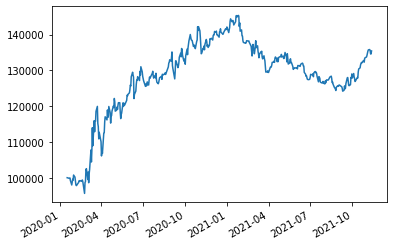

In [13]:
#Todo:
r_df = results['result_df']


# Calculate the Absolute Return of our trend-following trading strategy
absolute_return_tf = (r_df['account_val'].iloc[-1]-starting_capital)/starting_capital
print(f"absolute_return_tf: %{np.round(absolute_return_tf,2)*100}")

# Calculate the CAGR or our trend-following trading strategy
CAGR_tf = ((r_df['account_val'].iloc[-1]/starting_capital)**(252/len(df)))-1
print(f"CAGR_tf: %{np.round(CAGR_tf,2)*100}")

# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_tf = (r_df.account_val.pct_change().mean()/r_df.account_val.pct_change().std())*((252) **0.5)
print(f"information_ratio_tf: {np.round(information_ratio_tf,4)}")
#Plot the equity curve (hint: use 'account_val')
r_df.account_val.plot()

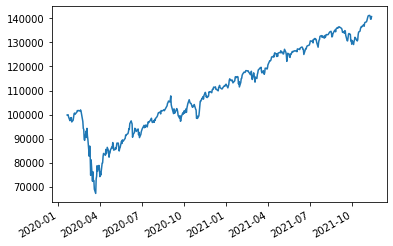

In [14]:
#Todo:
r_df = results['result_df']
# Calculate the Absolute Return of a buy-and-hold strategy in the same period
absolute_return_bh = ((r_df.iloc[-1].Close - r_df.Open.iloc[0])/r_df.Open.iloc[0])*100
# Calculate the CAGR or our trend-following trading strategy
CAGR_bh = ((r_df.Close.iloc[-1]/r_df.Open.iloc[0])**(356/(r_df.index[-1] - r_df.index[0]).days))-1
# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_bh = (r_df.Close.pct_change().mean()/r_df.Close.pct_change().std())*((252)**0.5)

#Plot the equity curve (hint: use 'close' returns and your initial capital value to generate an equity curve)
((r_df.Close.pct_change().dropna()+1).cumprod()*starting_capital).plot()

In [15]:
#Todo - optional, below:
# Copy any of the code from above to new cells below, and see how changing the symbol, dates and trend parameters changes the performance
# Can you beat the reference implementation?